In [1]:
from geotessera import GeoTessera
import numpy as np

# Initialize the client
gt = GeoTessera()

# Method 1: Fetch a single tile
embedding, crs, transform = gt.fetch_embedding(lon=0.15, lat=52.05, year=2024)
print(f"Shape: {embedding.shape}")  # e.g., (1200, 1200, 128)
print(f"CRS: {crs}")  # Coordinate reference system from landmask

# Method 2: Fetch all tiles in a bounding box

bbox = (-1.671467,42.804532,-1.599112,42.838276)  # (min_lon, min_lat, max_lon, max_lat)
tiles_to_fetch = gt.registry.load_blocks_for_region(bounds=bbox, year=2024)
embeddings = gt.fetch_embeddings(tiles_to_fetch)

for year, tile_lon, tile_lat, embedding_array, crs, transform in embeddings:
    print(f"Tile ({tile_lat}, {tile_lon}): {embedding_array.shape}")

Shape: (1139, 729, 128)
CRS: EPSG:32631
Tile (42.85, -1.65): (1124, 835, 128)
Tile (42.85, -1.55): (1125, 836, 128)


## Clustering Analysis

Perform K-means clustering on the embeddings and visualize the results.

In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare embeddings for clustering
# Flatten the spatial dimensions and keep only the embedding dimension
# Shape: (1200, 1200, 128) -> (1200*1200, 128)
embeddings_flat = embedding.reshape(-1, embedding.shape[-1])

print(f"Embeddings shape for clustering: {embeddings_flat.shape}")
print(f"Total pixels: {embeddings_flat.shape[0]}")

Embeddings shape for clustering: (830331, 128)
Total pixels: 830331


In [3]:
# Perform K-means clustering
n_clusters = 5
print(f"Performing K-means clustering with {n_clusters} clusters...")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings_flat)

# Reshape labels back to spatial dimensions
cluster_map = cluster_labels.reshape(embedding.shape[0], embedding.shape[1])

print(f"Clustering completed!")
print(f"Cluster distribution: {np.bincount(cluster_labels)}")

Performing K-means clustering with 5 clusters...
Clustering completed!
Cluster distribution: [ 99926 224974 277123  78748 149560]


Performing PCA for 2D visualization...


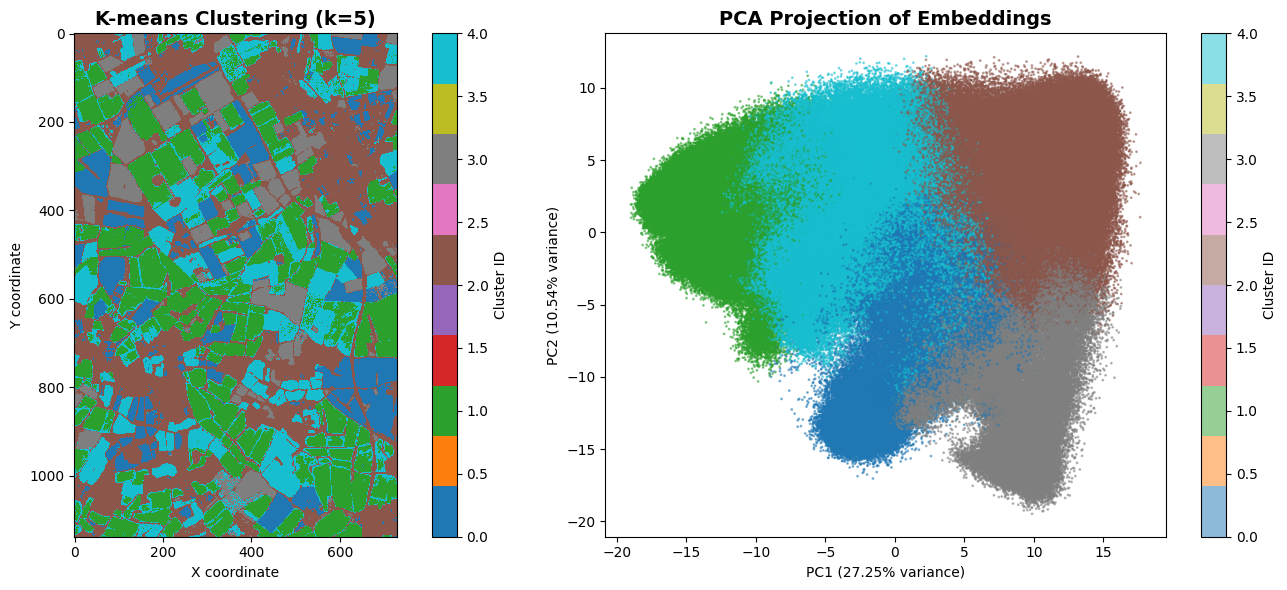


Total explained variance: 37.79%


In [4]:
# Visualize the clustering result
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Cluster map
im1 = axes[0].imshow(cluster_map, cmap='tab10', interpolation='nearest')
axes[0].set_title(f'K-means Clustering (k={n_clusters})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X coordinate')
axes[0].set_ylabel('Y coordinate')
plt.colorbar(im1, ax=axes[0], label='Cluster ID')

# Plot 2: PCA visualization of clusters
print("Performing PCA for 2D visualization...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_flat)

scatter = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                          c=cluster_labels, cmap='tab10', 
                          alpha=0.5, s=1)
axes[1].set_title('PCA Projection of Embeddings', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[1], label='Cluster ID')

plt.tight_layout()
plt.show()

print(f"\nTotal explained variance: {sum(pca.explained_variance_ratio_):.2%}")

## Clustering Analysis for BBox (Multiple Tiles)

Process and cluster embeddings from all tiles in the bounding box.

In [5]:
# Collect all embeddings from the bounding box
bbox_embeddings_list = []
tile_info = []

# Re-fetch embeddings from bbox (since generator was already consumed)
tiles_to_fetch = gt.registry.load_blocks_for_region(bounds=bbox, year=2024)
embeddings_gen = gt.fetch_embeddings(tiles_to_fetch)

print("Collecting embeddings from all tiles in bounding box...")
for year, tile_lon, tile_lat, embedding_array, crs, transform in embeddings_gen:
    print(f"Processing tile ({tile_lat:.2f}, {tile_lon:.2f}): {embedding_array.shape}")
    # Flatten spatial dimensions: (H, W, 128) -> (H*W, 128)
    flat_emb = embedding_array.reshape(-1, embedding_array.shape[-1])
    bbox_embeddings_list.append(flat_emb)
    tile_info.append({
        'lat': tile_lat,
        'lon': tile_lon,
        'shape': embedding_array.shape,
        'n_pixels': flat_emb.shape[0]
    })

# Concatenate all embeddings
bbox_embeddings_all = np.vstack(bbox_embeddings_list)

print(f"\n✓ Total embeddings collected: {bbox_embeddings_all.shape}")
print(f"✓ Number of tiles: {len(bbox_embeddings_list)}")
print(f"✓ Total pixels across all tiles: {bbox_embeddings_all.shape[0]:,}")

Processing tile (42.85, -1.65): (1124, 835, 128)
Processing tile (42.85, -1.55): (1125, 836, 128)

✓ Total embeddings collected: (1879040, 128)
✓ Number of tiles: 2
✓ Total pixels across all tiles: 1,879,040


In [6]:
# Perform K-means clustering on all bbox embeddings
n_clusters_bbox = 6
print(f"Performing K-means clustering on all tiles with {n_clusters_bbox} clusters...")

kmeans_bbox = KMeans(n_clusters=n_clusters_bbox, random_state=42, n_init=10, verbose=1)
cluster_labels_bbox = kmeans_bbox.fit_predict(bbox_embeddings_all)

print(f"\n✓ Clustering completed!")
print(f"Cluster distribution:")
for i, count in enumerate(np.bincount(cluster_labels_bbox)):
    print(f"  Cluster {i}: {count:,} pixels ({count/len(cluster_labels_bbox)*100:.2f}%)")

Performing K-means clustering on all tiles with 6 clusters...
Initialization complete
Iteration 0, inertia 826785664.0.
Iteration 1, inertia 508507520.0.
Iteration 2, inertia 491768544.0.
Iteration 3, inertia 485691616.0.
Iteration 4, inertia 483595232.0.
Iteration 5, inertia 482960672.0.
Iteration 6, inertia 482711296.0.
Iteration 7, inertia 482583072.0.
Iteration 8, inertia 482509888.0.
Iteration 9, inertia 482468288.0.
Iteration 10, inertia 482444000.0.
Iteration 11, inertia 482428864.0.
Iteration 12, inertia 482418240.0.
Iteration 13, inertia 482411200.0.
Iteration 14, inertia 482406208.0.
Iteration 15, inertia 482402944.0.
Iteration 16, inertia 482401664.0.
Iteration 17, inertia 482400672.0.
Iteration 18, inertia 482399360.0.
Iteration 19, inertia 482397984.0.
Iteration 20, inertia 482397856.0.
Iteration 21, inertia 482398272.0.
Converged at iteration 21: center shift 0.0003550224064383656 within tolerance 0.0003785393782891333.
Initialization complete
Iteration 0, inertia 7981968

In [7]:
# Reconstruct cluster maps for each tile
cluster_maps_per_tile = []
start_idx = 0

for tile in tile_info:
    n_pixels = tile['n_pixels']
    tile_labels = cluster_labels_bbox[start_idx:start_idx + n_pixels]
    # Reshape back to spatial dimensions
    h, w = tile['shape'][0], tile['shape'][1]
    tile_cluster_map = tile_labels.reshape(h, w)
    cluster_maps_per_tile.append(tile_cluster_map)
    start_idx += n_pixels

print(f"✓ Created cluster maps for {len(cluster_maps_per_tile)} tiles")

✓ Created cluster maps for 2 tiles


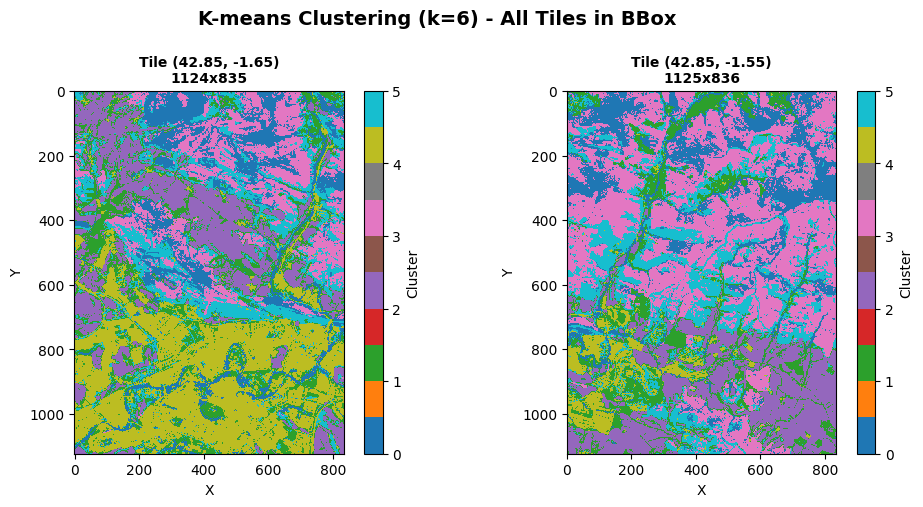

In [8]:
# Visualize cluster maps for all tiles
n_tiles = len(cluster_maps_per_tile)
cols = min(3, n_tiles)
rows = (n_tiles + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
if n_tiles == 1:
    axes = np.array([axes])
axes = axes.flatten()

for idx, (cluster_map, tile) in enumerate(zip(cluster_maps_per_tile, tile_info)):
    im = axes[idx].imshow(cluster_map, cmap='tab10', interpolation='nearest', vmin=0, vmax=n_clusters_bbox-1)
    axes[idx].set_title(f"Tile ({tile['lat']:.2f}, {tile['lon']:.2f})\n{tile['shape'][0]}x{tile['shape'][1]}", 
                        fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('Y')
    plt.colorbar(im, ax=axes[idx], label='Cluster')

# Hide unused subplots
for idx in range(n_tiles, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'K-means Clustering (k={n_clusters_bbox}) - All Tiles in BBox', 
             fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

In [9]:
import rasterio
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling
import matplotlib.colors as mcolors

# First, collect the georeferenced data for each tile
tiles_to_fetch = gt.registry.load_blocks_for_region(bounds=bbox, year=2024)
embeddings_gen = gt.fetch_embeddings(tiles_to_fetch)

tile_data = []
for idx, (year, tile_lon, tile_lat, embedding_array, tile_crs, tile_transform) in enumerate(embeddings_gen):
    cluster_map = cluster_maps_per_tile[idx]
    tile_data.append({
        'cluster_map': cluster_map,
        'crs': tile_crs,
        'transform': tile_transform,
        'bounds': rasterio.transform.array_bounds(
            cluster_map.shape[0], 
            cluster_map.shape[1], 
            tile_transform
        )
    })
    print(f"Tile {idx}: bounds = {tile_data[-1]['bounds']}")

print(f"\n✓ Collected {len(tile_data)} georeferenced tiles")

Tile 0: bounds = (606133.215021294, 4739420.725288692, 614483.215021294, 4750660.725288692)
Tile 1: bounds = (614297.4260221977, 4739551.402396928, 622657.4260221977, 4750801.402396928)

✓ Collected 2 georeferenced tiles


In [10]:
# Calculate the global bounding box for all tiles
all_bounds = [t['bounds'] for t in tile_data]
min_x = min(b[0] for b in all_bounds)
min_y = min(b[1] for b in all_bounds)
max_x = max(b[2] for b in all_bounds)
max_y = max(b[3] for b in all_bounds)

print(f"Global bounds: ({min_x}, {min_y}, {max_x}, {max_y})")

# Determine the output size (use the resolution from the first tile)
first_transform = tile_data[0]['transform']
pixel_size_x = first_transform.a
pixel_size_y = -first_transform.e  # Negative because y decreases

width = int((max_x - min_x) / pixel_size_x)
height = int((max_y - min_y) / pixel_size_y)

print(f"Mosaic dimensions: {width} x {height} pixels")
print(f"Pixel size: {pixel_size_x} x {pixel_size_y}")

# Create the output transform
output_transform = from_bounds(min_x, min_y, max_x, max_y, width, height)

# Initialize the mosaic with -1 (will represent no data / black)
mosaic = np.full((height, width), -1, dtype=np.int32)

print(f"\n✓ Created empty mosaic of shape {mosaic.shape}")

Global bounds: (606133.215021294, 4739420.725288692, 622657.4260221977, 4750801.402396928)
Mosaic dimensions: 1652 x 1138 pixels
Pixel size: 10.0 x 10.0

✓ Created empty mosaic of shape (1138, 1652)


Performing PCA on all bbox embeddings...
Sampling 50000 points from 1,879,040 for visualization...


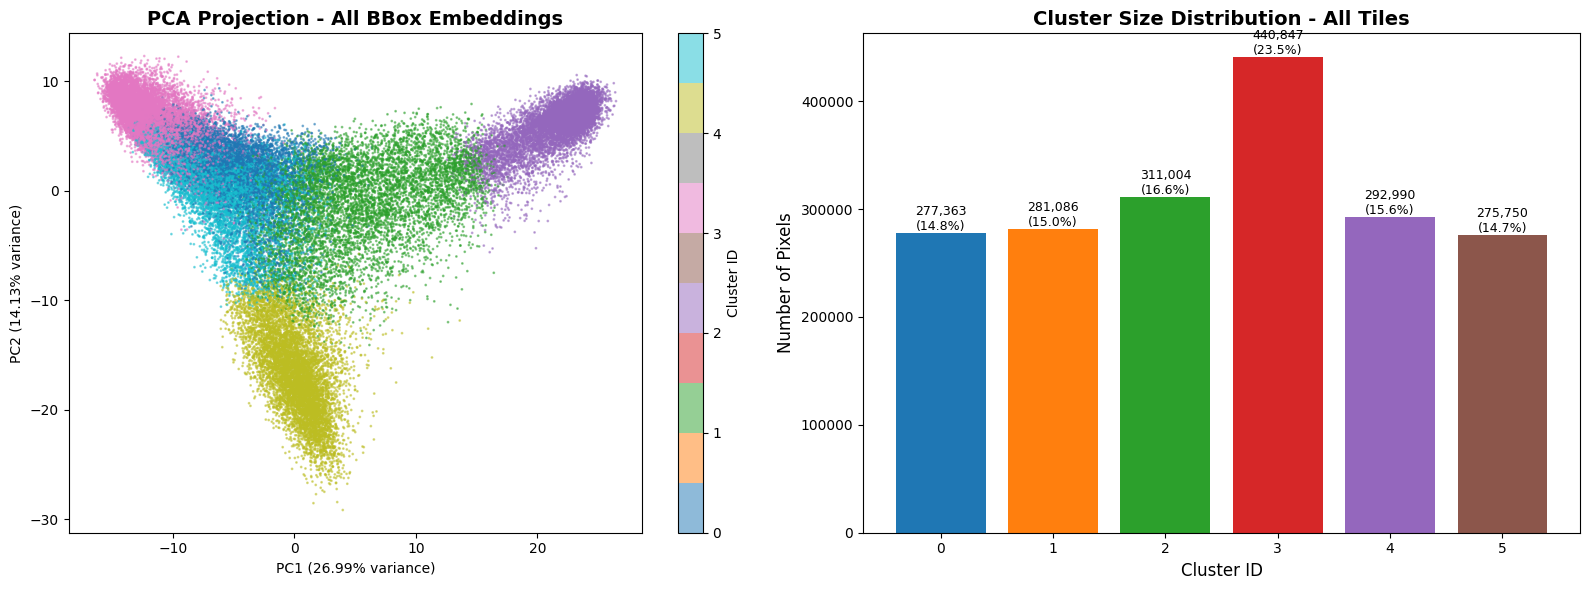


✓ Total explained variance (2 components): 41.13%


In [11]:
# PCA visualization and cluster statistics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: PCA projection with clusters
print("Performing PCA on all bbox embeddings...")
pca_bbox = PCA(n_components=2)

# Sample if too many points for visualization
max_points = 50000
if len(bbox_embeddings_all) > max_points:
    print(f"Sampling {max_points} points from {len(bbox_embeddings_all):,} for visualization...")
    sample_idx = np.random.choice(len(bbox_embeddings_all), max_points, replace=False)
    embeddings_sample = bbox_embeddings_all[sample_idx]
    labels_sample = cluster_labels_bbox[sample_idx]
else:
    embeddings_sample = bbox_embeddings_all
    labels_sample = cluster_labels_bbox

embeddings_2d_bbox = pca_bbox.fit_transform(embeddings_sample)

scatter = axes[0].scatter(embeddings_2d_bbox[:, 0], embeddings_2d_bbox[:, 1],
                          c=labels_sample, cmap='tab10',
                          alpha=0.5, s=1)
axes[0].set_title('PCA Projection - All BBox Embeddings', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca_bbox.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_bbox.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[0], label='Cluster ID')

# Plot 2: Cluster size distribution
cluster_counts_bbox = np.bincount(cluster_labels_bbox)
colors = plt.cm.tab10(np.arange(n_clusters_bbox))

bars = axes[1].bar(range(n_clusters_bbox), cluster_counts_bbox, color=colors)
axes[1].set_xlabel('Cluster ID', fontsize=12)
axes[1].set_ylabel('Number of Pixels', fontsize=12)
axes[1].set_title('Cluster Size Distribution - All Tiles', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(n_clusters_bbox))

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, cluster_counts_bbox)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({count/len(cluster_labels_bbox)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n✓ Total explained variance (2 components): {sum(pca_bbox.explained_variance_ratio_):.2%}")

In [12]:
# Place each tile in the correct position in the mosaic
for idx, tile in enumerate(tile_data):
    cluster_map = tile['cluster_map'].astype(np.int32)
    tile_transform = tile['transform']
    
    # Calculate pixel offset in the mosaic
    tile_min_x = tile_transform.c
    tile_max_y = tile_transform.f
    
    col_offset = int((tile_min_x - min_x) / pixel_size_x)
    row_offset = int((max_y - tile_max_y) / pixel_size_y)
    
    tile_height, tile_width = cluster_map.shape
    
    # Place the tile in the mosaic
    mosaic[row_offset:row_offset+tile_height, col_offset:col_offset+tile_width] = cluster_map
    
    print(f"Placed tile {idx} at offset ({row_offset}, {col_offset})")

print(f"\n✓ Mosaic assembly complete!")

Placed tile 0 at offset (14, 0)
Placed tile 1 at offset (0, 816)

✓ Mosaic assembly complete!


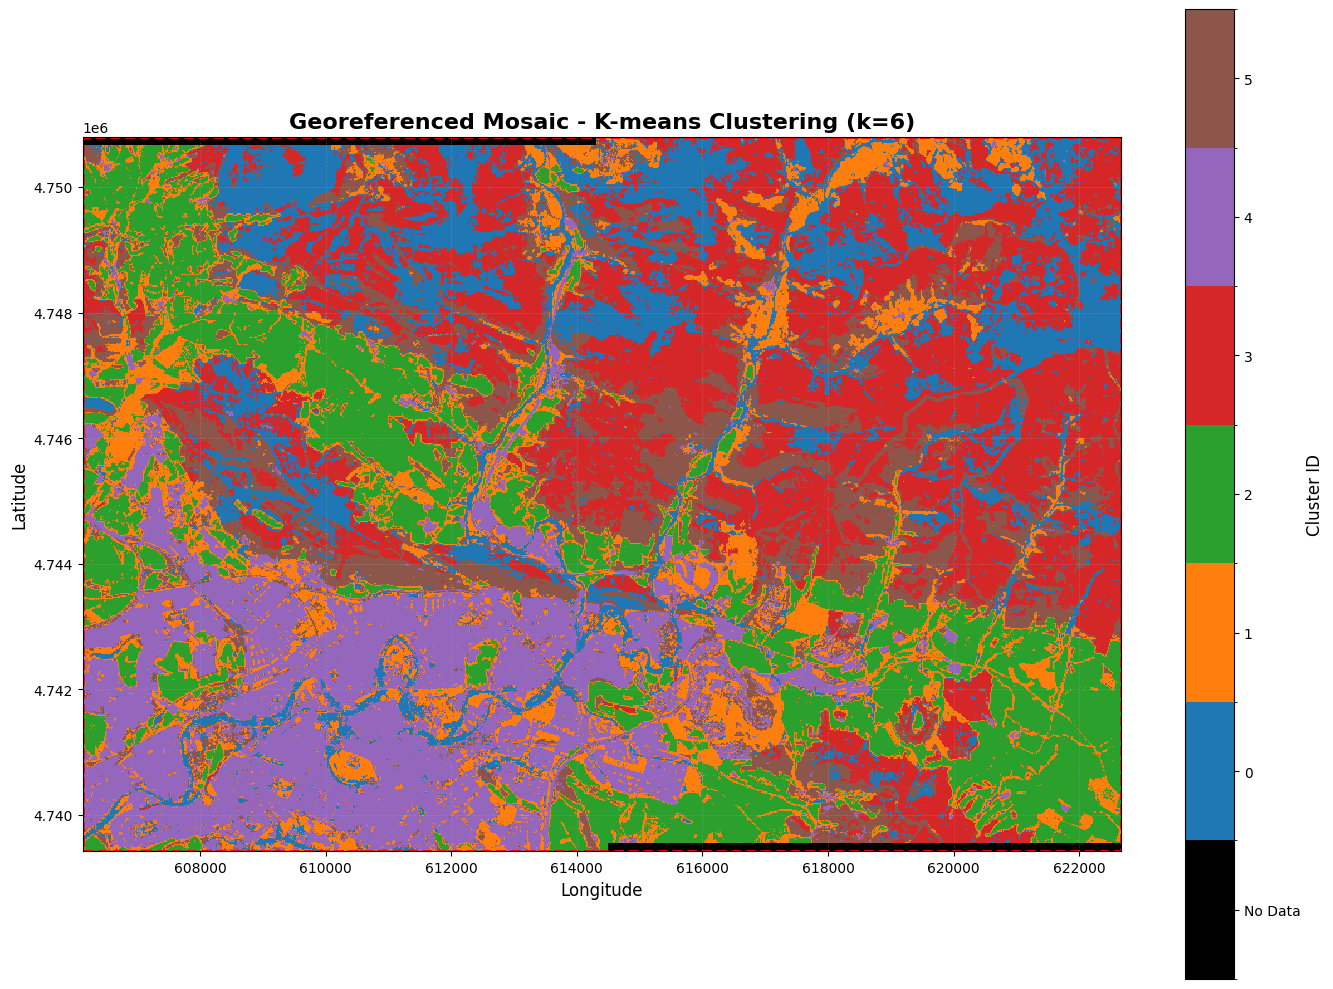


✓ Georeferenced mosaic displayed!
Coordinate Reference System: EPSG:32630
Bounding box: (-1.671467, 42.804532, -1.599112, 42.838276)


In [13]:
# Create a custom colormap with black for no data
# Use tab10 for the clusters, but set -1 to black
cmap = plt.cm.tab10.copy()
colors_list = [cmap(i) for i in range(n_clusters_bbox)]
# Add black for no-data value (-1)
colors_list.insert(0, (0, 0, 0, 1))  # Black with full opacity

# Create custom colormap
custom_cmap = mcolors.ListedColormap(colors_list)
bounds = list(range(-1, n_clusters_bbox + 1))
norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)

# Visualize the georeferenced mosaic
fig, ax = plt.subplots(figsize=(14, 10))

im = ax.imshow(mosaic, cmap=custom_cmap, norm=norm, interpolation='nearest',
               extent=[min_x, max_x, min_y, max_y])

ax.set_title(f'Georeferenced Mosaic - K-means Clustering (k={n_clusters_bbox})', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Create colorbar with proper labels
cbar = plt.colorbar(im, ax=ax, ticks=np.arange(-0.5, n_clusters_bbox, 1))
cbar.set_label('Cluster ID', fontsize=12)
cbar.ax.set_yticklabels(['No Data'] + [str(i) for i in range(n_clusters_bbox)])

# Add grid for reference
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Add bounding box outline
from matplotlib.patches import Rectangle
rect = Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                 linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
ax.add_patch(rect)

plt.tight_layout()
plt.show()

print(f"\n✓ Georeferenced mosaic displayed!")
print(f"Coordinate Reference System: {tile_data[0]['crs']}")
print(f"Bounding box: {bbox}")